In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from sklearn.linear_model import LinearRegression
# import utils as ut

In [3]:
def get_D_alpha(traj, min_length=10, numPoints=5):
    if traj.shape[0]<min_length:
        return np.nan, np.nan, np.nan, np.nan,np.nan
    model = LinearRegression()
    x = np.log10(traj.loc[traj.correction=="corrected","lags(s)"])
    y = np.log10(traj.loc[traj.correction=="corrected","MSD(µm^2)"])
    sampleWeight = traj.loc[traj.correction=="corrected","weight"]
    #print(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints], sampleWeight.to_numpy()[:numPoints])
    model.fit(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints])#, sample_weight = sampleWeight.to_numpy()[:numPoints])
    y_pred = model.predict(x.to_numpy().reshape(-1,1))
    return model.intercept_, model.coef_[0],traj.iloc[0].treatment,traj.iloc[0].file,traj.iloc[0].channel#10**y_pred,10**x

# Open all the data

In [3]:
list_files_cor = glob.glob('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/*/msd_corrected__*')
list_files_uncor = glob.glob('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/*/msd_uncorrected__*')

In [4]:
list_files = list_files_cor + list_files_uncor

In [5]:
list_files_cor

['/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.nd_denoised-72ed37bb934c4d07/msd_corrected__0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.nd_denoised-72ed37bb934c4d07.csv',
 '/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/0231002_Rad21-Halo_SPT_1C5_NIPBL_noaux_nodtag_4.nd_denoised-8bef5a70b3d8ff2b/msd_corrected__0231002_Rad21-Halo_SPT_1C5_NIPBL_noaux_nodtag_4.nd_denoised-8bef5a70b3d8ff2b.csv',
 '/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/0231004_Rad21-Halo_SPT_1E4_PDS5_6haux_nodtag_2.nd_denoised-38a16620cd2763f9/msd_corrected__0231004_Rad21-Halo_SPT_1E4_PDS5_6haux_nodtag_2.nd_denoised-38a16620cd2763f9.csv',
 '/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/0231006_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.nd_denoised-60a20767d8643214/msd_corrected__0231006_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.nd_denoised-60a20767d8643

In [8]:
list_files_cor[0].split('/')

['',
 'tungstenfs',
 'scratch',
 'ggiorget',
 'nessim',
 'cohesin_live_cell_analysis',
 'results',
 'for_pia',
 '0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.nd_denoised-72ed37bb934c4d07',
 'msd_corrected__0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.nd_denoised-72ed37bb934c4d07.csv']

In [6]:
for i in list_files:
    if 'uncorrected' in i:
        print(i)

/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/0231005_Rad21-Halo_SPT_1C5_NIPBL_6haux_nodtag_1.nd_denoised-69a92928a9fc1f88/msd_uncorrected__0231005_Rad21-Halo_SPT_1C5_NIPBL_6haux_nodtag_1.nd_denoised-69a92928a9fc1f88.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.nd_denoised-72ed37bb934c4d07/msd_uncorrected__0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.nd_denoised-72ed37bb934c4d07.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/0231006_Rad21-Halo_SPT_1E4_PDS5_noaux_6hdtag_1.nd_denoised-9603fb9d292ed4f0/msd_uncorrected__0231006_Rad21-Halo_SPT_1E4_PDS5_noaux_6hdtag_1.nd_denoised-9603fb9d292ed4f0.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/0231002_Rad21-Halo_SPT_1C5_NIPBL_noaux_nodtag_4.nd_denoised-8bef5a70b3d8ff2b/msd_uncorrected__0231002_Rad21-Halo_SPT_1C5_NIPBL_noaux_nodtag_4.nd_denoised-8bef5a70b3d8f

In [11]:
df_list = []
for file in list_files:
    # if 'test_tracking_without_gaps' in file:
    #     print(file)
    #     continue
    df = pd.read_csv(file)
    df.tamsd = df.tamsd*(0.16**2) # from pixel to µm
    df.lags = df.lags*10 # from frame to seconds
    df.tamsd = df.tamsd - (2*(0.035**2)) # subtract the localization error
    df.rename(columns={'tamsd':'MSD(µm^2)','lags':'lags(s)'}, inplace=True)

    if 'NIPBL' in file:
        df['cell_type'] = ['NIPBL']*len(df)
    if 'sororin' in file or 'Sororin' in file:
        df['cell_type'] = ['sororin']*len(df)
    if 'WT' in file:
        df['cell_type'] = ['WT']*len(df)
    if 'PDS5' in file:
        df['cell_type'] = ['PDS5']*len(df)
    
    if '6haux' in file or '3haux' in file:
        df['treatment_aid'] = ['treated']*len(df)
    if 'noaux' in file:
        df['treatment_aid'] = ['untreated']*len(df)

    if '6hdtag' in file:
        df['treatment_dtag'] = ['treated']*len(df)
    if 'nodtag' in file:
        df['treatment_dtag'] = ['untreated']*len(df)
    
    if 'corrected' in file:
        df['correction'] = ['corrected']*len(df)
    if 'uncorrected' in file:
        df['correction'] = ['uncorrected']*len(df)


    df['file'] = [file.split('/')[8]]*len(df)
    #df.replace('w1','cohesin', inplace=True)
    df.replace('w2','DNA', inplace=True)
    df_list.append(df)

df_combined = pd.concat(df_list)


In [12]:
df_combined

,Unnamed: 0,lags(s),MSD(µm^2),weight,uniqueid,track_id,trStart,channel,cell_type,treatment_aid,treatment_dtag,correction,file
0,0,10.0,0.155651,40.0,1a91c0f8eb89be1c,2669,0,DNA,WT,untreated,untreated,corrected,0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.n...
1,1,20.0,0.206284,39.0,1a91c0f8eb89be1c,2669,0,DNA,WT,untreated,untreated,corrected,0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.n...
2,2,30.0,0.418489,39.0,1a91c0f8eb89be1c,2669,0,DNA,WT,untreated,untreated,corrected,0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.n...
3,3,40.0,0.568875,37.0,1a91c0f8eb89be1c,2669,0,DNA,WT,untreated,untreated,corrected,0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.n...
4,4,50.0,0.409371,38.0,1a91c0f8eb89be1c,2669,0,DNA,WT,untreated,untreated,corrected,0231002_Rad21-Halo_SPT_1G6_WT_noaux_nodtag_1.n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10206,13,140.0,0.775700,14.0,ca1bb7bf1e71800b,6819,146,DNA,PDS5,untreated,untreated,uncorrected,0231001_Rad21-Halo_SPT_1E4_PDS5_noaux_nodtag_1...
10207,14,150.0,0.712404,12.0,ca1bb7bf1e71800b,6819,146,DNA,PDS5,untreated,untreated,uncorrected,0231001_Rad21-Halo_SPT_1E4_PDS5_noaux_nodtag_1...
10208,15,160.0,0.786276,12.0,ca1bb7bf1e71800b,6819,146,DNA,PDS5,untreated,untreated,uncorrected,0231001_Rad21-Halo_SPT_1E4_PDS5_noaux_nodtag_1...
10209,16,170.0,1.003182,12.0,ca1bb7bf1e71800b,6819,146,DNA,PDS5,untreated,untreated,uncorrected,0231001_Rad21-Halo_SPT_1E4_PDS5_noaux_nodtag_1...


In [37]:
df_NIPBL_untreated = df_combined[(df_combined.cell_type == 'NIPBL')&(df_combined.treatment_aid == 'untreated')].copy(deep=True)
df_NIPBL_treated = df_combined[(df_combined.cell_type == 'NIPBL')&(df_combined.treatment_aid == 'treated')].copy(deep=True)

df_NIPBL = pd.concat([df_NIPBL_untreated, df_NIPBL_treated])

Text(0.5, 0.98, 'NIPBL')

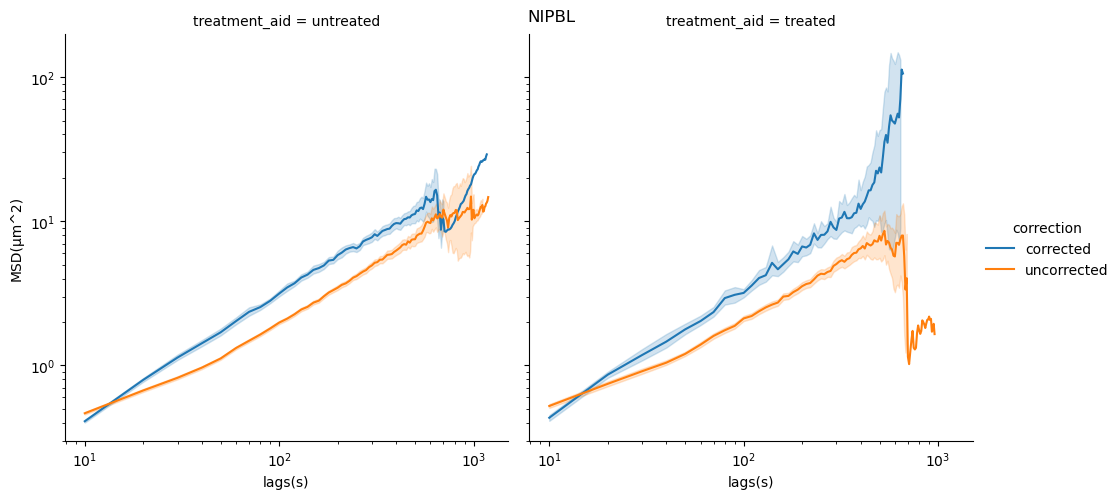

In [38]:
a = sns.relplot(data=df_NIPBL, x='lags(s)', y='MSD(µm^2)', hue='correction', kind='line',col='treatment_aid' )
plt.xscale('log')
plt.yscale('log')
a.fig.suptitle('NIPBL')

In [34]:
df_PDS5_untreated = df_combined[(df_combined.cell_type == 'PDS5')&(df_combined.treatment_aid == 'untreated')].copy(deep=True)
df_PDS5_treated = df_combined[(df_combined.cell_type == 'PDS5')&(df_combined.treatment_aid == 'treated')].copy(deep=True)

df_PDS5 = pd.concat([df_PDS5_untreated, df_PDS5_treated])

In [35]:
df_PDS5.treatment_dtag.unique()

array(['untreated', 'treated'], dtype=object)

In [36]:
a = sns.relplot(data=df_PDS5[df_PDS5.treatment_aid == 'untreated'], x='lags(s)', y='MSD(µm^2)', hue='correction', kind='line',col= 'treatmemt_aid')
plt.xscale('log')
plt.yscale('log')
a.fig.suptitle('PDS5')

ValueError: Could not interpret value `treatmemt_aid` for parameter `col`

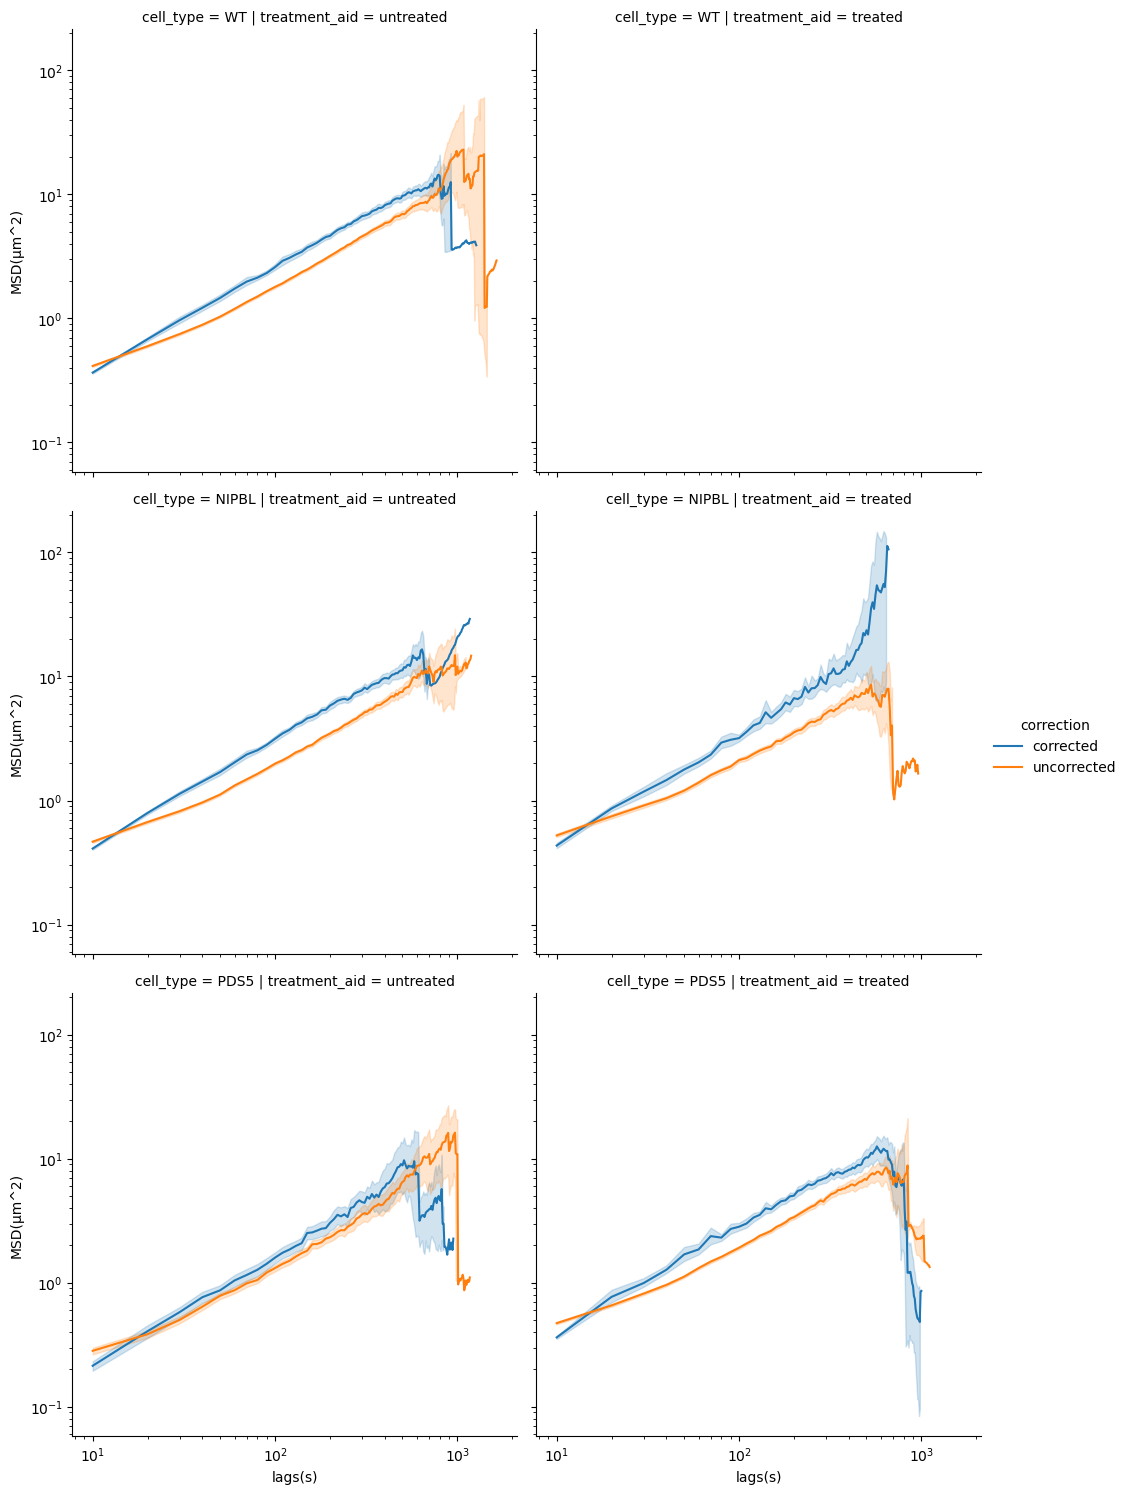

In [24]:
a = sns.relplot(data=df_combined, x='lags(s)', y='MSD(µm^2)', hue='correction', kind='line',col='treatment_aid',row='cell_type')
plt.xscale('log')
plt.yscale('log')

# Analysis on the tracking GT movie

In [2]:
df_cor = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/20230823_tracking_gt_2D5_25pM_30mW_2s_denoised/msd_corrected__20230823_tracking_gt_2D5_25pM_30mW_2s_denoised.csv')
df_uncor = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/20230823_tracking_gt_2D5_25pM_30mW_2s_denoised/msd_uncorrected__20230823_tracking_gt_2D5_25pM_30mW_2s_denoised.csv')

In [3]:
df_cor['correction'] = ['corrected']*len(df_cor)
df_uncor['correction'] = ['uncorrected']*len(df_uncor)

df_combined = pd.concat([df_cor,df_uncor])

In [4]:
df_combined

,Unnamed: 0,lags,tamsd,weight,uniqueid,track_id,trStart,channel,correction
0,0,1.0,0.963014,10.0,f40c838f3732717e,326,0,w1,corrected
1,0,1.0,0.932791,15.0,e7cc6eee122010b1,355,0,w1,corrected
2,1,2.0,1.227483,14.0,e7cc6eee122010b1,355,0,w1,corrected
3,2,3.0,1.105493,13.0,e7cc6eee122010b1,355,0,w1,corrected
4,3,4.0,1.046783,12.0,e7cc6eee122010b1,355,0,w1,corrected
...,...,...,...,...,...,...,...,...,...
52014,9,10.0,5.212532,14.0,0d04a8f3a5165e78,9117,275,w2,uncorrected
52015,10,11.0,5.185466,13.0,0d04a8f3a5165e78,9117,275,w2,uncorrected
52016,11,12.0,6.346598,12.0,0d04a8f3a5165e78,9117,275,w2,uncorrected
52017,12,13.0,6.949104,11.0,0d04a8f3a5165e78,9117,275,w2,uncorrected


In [5]:
df_combined.tamsd = df_combined.tamsd*(0.16**2) # from pixel to µm
df_combined.lags = df_combined.lags*2 # from frame to seconds
df_combined.tamsd = df_combined.tamsd - (2*(0.035**2)) # subtract the localization error
df_combined.rename(columns={'tamsd':'MSD(µm^2)','lags':'lags(s)'}, inplace=True)

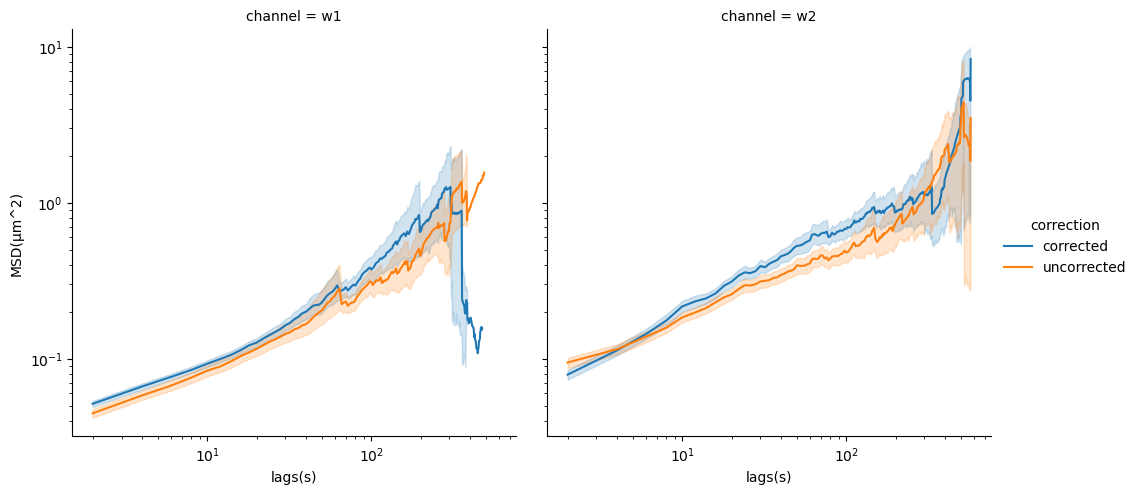

In [98]:
sns.relplot(data=df_combined, x='lags(s)', y='MSD(µm^2)', col='channel', kind='line',hue='correction')
plt.xscale('log')
plt.yscale('log')

In [45]:
df_cor


,Unnamed: 0,lags,tamsd,weight,uniqueid,track_id,trStart,channel,correction
0,0,1,1.528354,40,5738480ab1f1cabe,369,0,w1,corrected
1,1,2,2.337286,39,5738480ab1f1cabe,369,0,w1,corrected
2,2,3,3.180728,38,5738480ab1f1cabe,369,0,w1,corrected
3,3,4,3.685858,37,5738480ab1f1cabe,369,0,w1,corrected
4,4,5,4.633962,36,5738480ab1f1cabe,369,0,w1,corrected
...,...,...,...,...,...,...,...,...,...
22230,15,16,3.139882,14,af6f212f1607ffa8,32988,253,w1,corrected
22231,16,17,3.146665,13,af6f212f1607ffa8,32988,253,w1,corrected
22232,17,18,3.306162,12,af6f212f1607ffa8,32988,253,w1,corrected
22233,18,19,3.142974,11,af6f212f1607ffa8,32988,253,w1,corrected


In [6]:
def get_D_alpha(traj, min_length=10, numPoints=5):
    if traj.shape[0]<min_length:
        return np.nan, np.nan, np.nan
    model = LinearRegression()
    x = np.log10(traj.loc[traj.correction=="corrected","lags(s)"])
    y = np.log10(traj.loc[traj.correction=="corrected","MSD(µm^2)"])
    sampleWeight = traj.loc[traj.correction=="corrected","weight"]
    #print(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints], sampleWeight.to_numpy()[:numPoints])
    
    try:
        model.fit(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints])#, sample_weight = sampleWeight.to_numpy()[:numPoints])
    except ValueError:
        return np.nan, np.nan, np.nan

    y_pred = model.predict(x.to_numpy().reshape(-1,1))
    return model.intercept_, model.coef_[0],traj.iloc[0].channel#10**y_pred,10**x

In [14]:
coefficients = df_combined.groupby(by="uniqueid").apply(get_D_alpha, min_length=10, numPoints=5).to_frame()
coefficients.head()

,0
uniqueid,
000dff18c034cbe1,"(-1.5592863177093597, 0.20675293402754277, w1)"
00185a4a6decca06,"(nan, nan, nan)"
0023f9111dfe1b5d,"(nan, nan, nan)"
002f9486c1db1d4b,"(-2.0405155075229464, 0.4160975427992566, w1)"
003a245fc86d8207,"(nan, nan, nan)"


In [15]:
coefficients['D(µm^2/s)'], coefficients['alpha'],coefficients['channel'] = zip(*coefficients.iloc[:,0])
coefficients['D(µm^2/s)'] = 10**coefficients['D(µm^2/s)']
coefficients.drop(columns=[0],inplace=True)

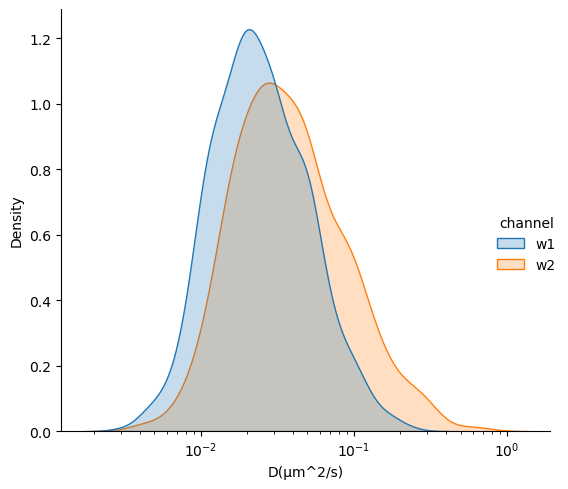

In [16]:
sns.displot(data=coefficients, x='D(µm^2/s)', hue='channel', kind='kde', fill=True, common_norm=False,log_scale=True)
plt.tight_layout()

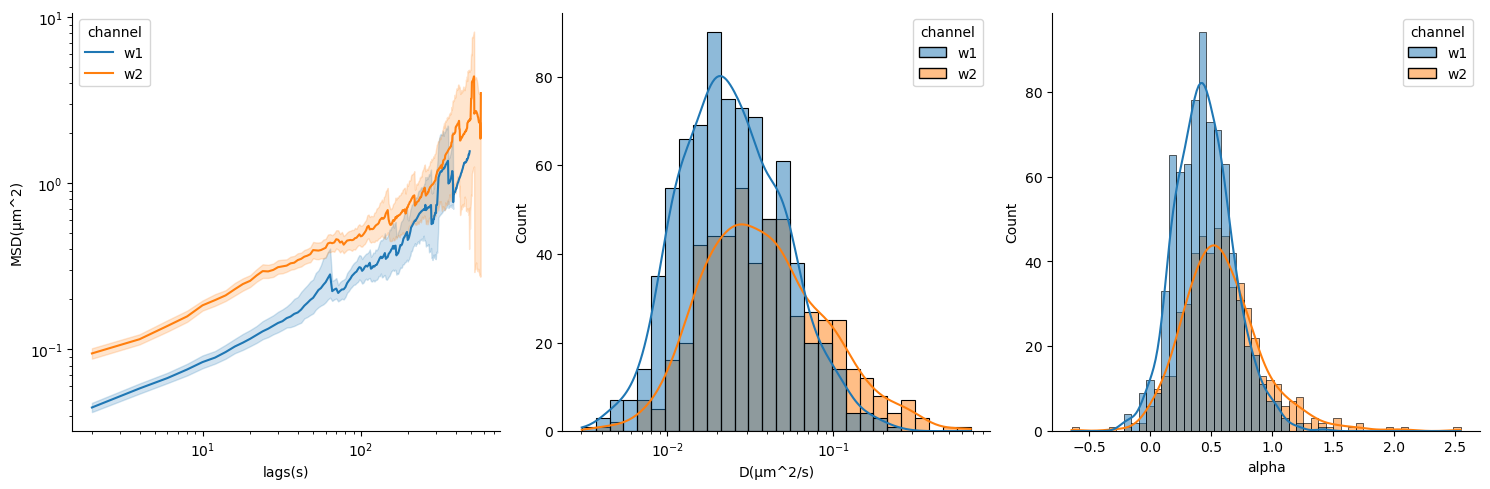

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

sns.lineplot(data=df_combined[df_combined.correction == 'uncorrected'], x='lags(s)', y='MSD(µm^2)', hue='channel', ax=ax[0])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
sns.histplot(data=coefficients, x='D(µm^2/s)', hue='channel', kde=True, common_norm=False,log_scale=True,ax=ax[1])

sns.histplot(data=coefficients, x='alpha', hue='channel', kde=True, log_scale=False, ax=ax[2])

sns.despine(top=True,right=True)
plt.tight_layout()
#plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/20230823_tracking_gt_2D5_25pM_30mW_2s_denoised/20230823_tracking_gt_2D5_25pM_30mW_2s_denoised.pdf')

In [18]:
df = coefficients.groupby(by='channel').mean()

In [19]:
df

,D(µm^2/s),alpha
channel,,
w1,0.031984,0.442887
w2,0.055456,0.587962


In [62]:
df_t = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/for_pia/20230823_tracking_gt_2D5_25pM_30mW_2s_denoised/tracks_corrected__20230823_tracking_gt_2D5_25pM_30mW_2s_denoised.csv')

In [81]:
df = df_t[df_t.channel == 'w2']#.groupby(by='track_id').count()

(0.0, 20.0)

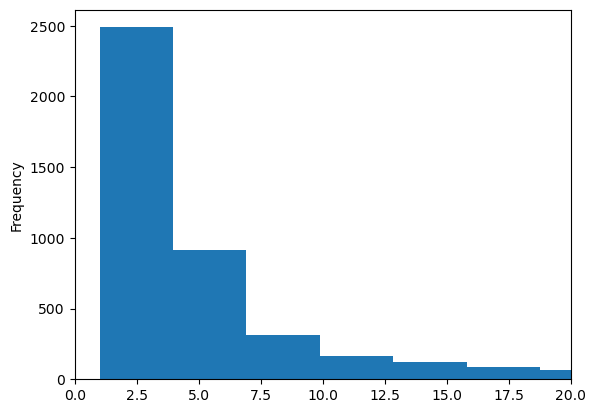

In [85]:
df.groupby(by='track_id').count().x.plot(kind='hist',bins=100)
plt.xlim(0,20)

In [82]:
n = df.groupby('track_id').size() > 23
n = n[n == True]
df_filtered_2 = df[df.track_id.isin(n.index.values)]

<AxesSubplot: ylabel='Frequency'>

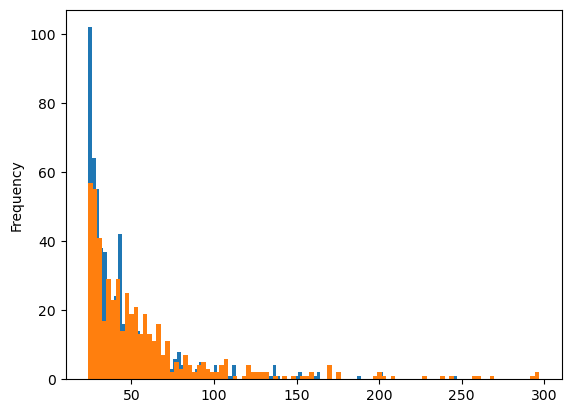

In [83]:
df_filtered.groupby(by='track_id').count().x.plot(kind='hist',bins=100)
df_filtered_2.groupby(by='track_id').count().x.plot(kind='hist',bins=100)

In [61]:
df_tracks_w1.groupby('track_id').count()

,Unnamed: 0,x,y,frame
track_id,,,,
1,15,15,15,15
3,24,24,24,24
4,3,3,3,3
5,6,6,6,6
6,11,11,11,11
...,...,...,...,...
34693,2,2,2,2
34695,2,2,2,2
34704,2,2,2,2
